In [1]:
import numpy as np
#from sklearn.metrics import jaccard_similarity_score

In [2]:
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv("data/comoda_data.csv")

In [5]:
df = df.replace(-1.0, np.nan)
df = df.dropna(how="any")

In [6]:
## CONSTANTS ASSUMPTION
sigma = 1
threshold = 0.1
columns = df.columns.tolist()
columns.remove("rating")
columns.append("rating")
df = df[columns]
X = df[columns[2:-1]]
y = df[columns[-1:]]
df = df.reset_index(drop=True)

## Clean Data

In [7]:
columns = df.columns

In [8]:
columns = columns[2:-1]

In [9]:
df_new = df.drop(['city','physical','director','movieCountry','movieLanguage','movieYear','genre1', 'genre2',
       'genre3', 'actor1', 'actor2', 'actor3','budget'], axis=1,)

In [10]:
from collections import defaultdict
new_size_of_feature = defaultdict(dict)
for column in df_new.columns:
    new_size_of_feature[column]['length'] = len(df_new[column].unique())
    new_size_of_feature[column]['names'] = df_new[column].unique()

In [11]:
sum_of_features = 0
for k,v in new_size_of_feature.items():
    sum_of_features += v['length']

In [12]:
sum_of_features

752

In [13]:
## Get Dummy Variables
for column in df_new.columns[2:-1]:
    df_col = pd.get_dummies(df_new[column], prefix=column)
    df_new = pd.concat([df_new, df_col], axis=1)

In [14]:
df_new = df_new.drop(['age', 'sex', 'country', 'time', 'daytype',
       'season', 'location', 'weather', 'social', 'endEmo', 'dominantEmo',
       'mood', 'decision', 'interaction'], axis=1)

In [15]:
df_new.shape

(1114, 77)

In [16]:
columns = df_new.columns.tolist()
columns.remove("rating")
columns.append("rating")
df_new = df_new[columns]

In [17]:
entriesToRemove = ('userID','itemID','city','physical','director','movieCountry','movieLanguage','movieYear','genre1', 'genre2',
       'genre3', 'actor1', 'actor2', 'actor3','budget','rating')

In [18]:
for k in entriesToRemove:
    new_size_of_feature.pop(k, None)

In [19]:
# for k,v in new_size_of_feature.items():
#     print(v['length'])

### Index limits for setting Constraints

In [20]:
index_limit=[]
for x in df.columns:
    index_limit.append(new_size_of_feature[x])

In [21]:
index_limit = index_limit[2:-12]

In [22]:
index_limit

[{'length': 21,
  'names': array([ 28.,  30.,  33.,  25.,  26.,  27.,  24.,  34.,  63.,  29.,  21.,
          22.,  15.,  18.,  17.,  23.,  31.,  20.,  35.,  19.,  36.])},
 {'length': 2, 'names': array([1, 2], dtype=int64)},
 {},
 {'length': 4, 'names': array([3, 2, 5, 4], dtype=int64)},
 {'length': 4, 'names': array([ 2.,  4.,  3.,  1.])},
 {'length': 3, 'names': array([ 2.,  1.,  3.])},
 {'length': 4, 'names': array([ 2.,  3.,  1.,  4.])},
 {'length': 3, 'names': array([ 1.,  2.,  3.])},
 {'length': 5, 'names': array([ 1.,  2.,  5.,  3.,  4.])},
 {'length': 7, 'names': array([ 2.,  3.,  1.,  5.,  7.,  6.,  4.])},
 {'length': 7, 'names': array([ 2.,  1.,  7.,  4.,  5.,  6.,  3.])},
 {'length': 7, 'names': array([ 2.,  3.,  7.,  5.,  4.,  6.,  1.])},
 {'length': 3, 'names': array([ 2.,  1.,  3.])},
 {},
 {'length': 2, 'names': array([ 2.,  1.])},
 {'length': 2, 'names': array([ 2.,  1.])}]

In [23]:
final_index_limit= []
for i in range(len(index_limit)):
    x = index_limit[i]
    try:
        final_index_limit.append(x['length'])
    except:
        pass

In [24]:
final_index_limit, sum(final_index_limit)

([21, 2, 4, 4, 3, 4, 3, 5, 7, 7, 7, 3, 2, 2], 74)

# Pyswarm Implementation

In [25]:
from pyswarm import pso
import time
from random import *

In [26]:
start_time = time.time()
#user_context = df_new.iloc[0][2:-1].tolist()
user_rating = df_new.rating.tolist()[:30]
def banana(x):
    lhs = 0.0
    square_error = 0.0
    for i in range(30):
        user_context = df_new.iloc[i][2:-1].tolist()
        lhs = np.dot(x,user_context)
#         for weight, context in zip(x, user_context):
#             lhs += weight * context
        square_error += (user_rating[i] - lhs)**2
    #print(square_error)
    return square_error/2

def con(x):
    con_index = []
    final_index_limit = [21, 2, 4, 4, 3, 4, 3, 5, 7, 7, 7, 3, 2, 2]
    start_index=0
    con_index = []
    for index in final_index_limit:
        temp = []
        temp.append(sum(x[start_index:start_index+index]) - 1)
        temp = temp*index
        con_index=con_index + temp
        start_index = index
    return con_index

lb = [0]*74
ub = [1]*74

#xopt, fopt = pso(banana,lb, ub,f_ieqcons=con,swarmsize=50,maxiter=200)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0010161399841308594 seconds ---


In [27]:
# print("----------------------Difference Between Ratings---------------------")
# for i in range(10):
#     rating = 0
#     count = 0
#     original_rating = df_new.iloc[i][-1]
#     predicted_rating = np.dot(xopt, df_new.iloc[i][2:-1].tolist())
#     print(predicted_rating, original_rating)
#     #print(str(float(original_rating - original_rating)))

In [28]:
# from sklearn.metrics import mean_squared_error

In [29]:
# original_rating = [df_new.iloc[i][-1] for i in range(1000)]
# predicted_rating = [np.dot(xopt, df_new.iloc[i][2:-1].tolist()) for i in range(1000)]
# print("----------------------  RMSE VALUE IS  ---------------------")
# mean_squared_error(original_rating,predicted_rating)

In [30]:
## Save Pso result to csv

In [31]:
# ## Append swarmsize, max_iter, the beginning of the result list
# pso_param = [740, 100]
# result = pso_param + xopt.tolist()

In [32]:
#np.savetxt("pso.csv", result, delimiter=",")

# Firefly Optimization Implementation

In [33]:
# user_rating = df_new.rating.tolist()[:20]

In [34]:
# from metaheuristic_algorithms.function_wrappers.abstract_wrapper import AbstractWrapper
# class MinimizeWeightsSumSquareError(AbstractWrapper):

#     def maximum_decision_variable_values(self):
#         return [1]*74

#     def minimum_decision_variable_values(self):
#         return [0]*74

#     def objective_function_value(self, decision_variable_values):
#         user_rating = df_new.rating.tolist()[:20]
#         lhs = 0.0
#         square_error = 0.0
#         for i in range(20):
#             user_context = df_new.iloc[i][2:-1].tolist()
#             lhs = np.dot(decision_variable_values,user_context)
#             square_error += (user_rating[i] - lhs)**2
#         return square_error/20

#     def initial_decision_variable_value_estimates(self):
#         return [0.0]*74

In [35]:
# import time

In [36]:
# from metaheuristic_algorithms.firefly_algorithm import FireflyAlgorithm
# start_time = time.time()
# #from metaheuristic_algorithms.function_wrappers.rosenbrook_function_wrapper import RosenbrookFunctionWrapper
# #from metaheuristic_algorithms.function_wrappers.nonsmooth_multipeak_function_wrapper import NonsmoothMultipeakFunctionWrapper
# minimize_weights_function_wrapper = MinimizeWeightsSumSquareError()

# number_of_variables = 74
# objective = "minimization"

# firefly_algo = FireflyAlgorithm(minimize_weights_function_wrapper, number_of_variables, objective)


# number_of_fireflies = 50
# maximun_generation = 100
# randomization_parameter_alpha = 0.1
# absorption_coefficient_gamma = 1.0

# # result = firefly_algo.search(number_of_fireflies = number_of_fireflies, 
# #                                maximun_generation = maximun_generation, 
# #                                randomization_parameter_alpha = randomization_parameter_alpha, 
# #                                absorption_coefficient_gamma = absorption_coefficient_gamma)
# #rint(result["best_decision_variable_values"])
# print("--- %s seconds ---" % (time.time() - start_time))
# #rint(result["best_objective_function_value"])

In [37]:
# print("----------------------Difference Between Ratings---------------------")
# for i in range(20):
#     rating = 0
#     count = 0
#     original_rating = df_new.iloc[i][-1]
#     predicted_rating = np.dot(result["best_decision_variable_values"], df_new.iloc[i][2:-1].tolist())
#     #print(predicted_rating, original_rating)
#     print(predicted_rating)
#     #print(str(float(original_rating - original_rating)))

In [38]:
# from sklearn.metrics import mean_squared_error

# original_rating = [df_new.iloc[i][-1] for i in range(1000)]
# predicted_rating = [np.dot(result["best_decision_variable_values"], df_new.iloc[i][2:-1].tolist()) for i in range(1000)]
# print("----------------------  RMSE VALUE IS  ---------------------")
# mean_squared_error(original_rating,predicted_rating)

In [39]:
# from sklearn.metrics import mean_squared_error
# def calculate_mse(weights):
#     original_rating = [df_new.iloc[i][-1] for i in range(1000)]
#     predicted_rating = [np.dot(weights, df_new.iloc[i][2:-1].tolist()) for i in range(1000)]
#     #print("----------------------  RMSE VALUE IS  ---------------------")
#     return mean_squared_error(original_rating,predicted_rating)

In [40]:
# def run_firefly_multiple_times():
#     number_of_fireflies = 60
#     randomization_parameter_alpha = 0.2
#     absorption_coefficient_gamma = 1.0
#     swarm_size = 100
#     indi_results = []
#     for max_iter in range(100,400,50):
#         print("Current number of Iteration", str(max_iter))
#         start_time = time.time()
#         result = firefly_algo.search(number_of_fireflies = number_of_fireflies, 
#                                maximun_generation = max_iter, 
#                                randomization_parameter_alpha = randomization_parameter_alpha, 
#                                absorption_coefficient_gamma = absorption_coefficient_gamma)
#         rmse = calculate_mse(result["best_decision_variable_values"])
#         print(rmse)
#         finish_time = time.time() - start_time
#         firefly_param = [number_of_fireflies, max_iter, finish_time, rmse]
#         indi_results.append(firefly_param + result["best_decision_variable_values"])
#     indi_results = np.array(indi_results)
#     np.savetxt("firefly.csv", indi_results, delimiter=",")

In [41]:
#run_firefly_multiple_times()

## Save firefly results to csv file here

In [42]:
# ## append fireflynum, max_iter to the beginning of weights array
# firefly_param = [740, 100]
# result_fire = firefly_param + result["best_decision_variable_values"].tolist()

In [43]:
# np.savetxt("firefly.csv", np.array(result_fire), delimiter=",")

## Firefly Weight

In [44]:
fire_weights = [  7.00000000e+01,   2.00000000e+02,   3.79900957e+02,
          4.76773859e+00,   1.68025248e-01,   6.33696638e-01,
          1.66857644e-01,   9.56715600e-01,   1.40681305e-02,
          5.67212948e-01,   1.00000000e+00,   6.86592048e-02,
          5.79232355e-01,   1.61788904e-01,   4.37825980e-01,
          3.69704405e-01,   0.00000000e+00,   4.01681141e-03,
          8.79106525e-01,   1.00000000e+00,   1.05052174e-01,
          1.07819948e-01,   2.72514379e-01,   3.28510792e-01,
          6.13944565e-01,   9.51533687e-02,   4.47570215e-01,
          1.30900553e-01,   2.16290656e-01,   6.44635553e-01,
          5.39704064e-01,   3.07633150e-01,   4.08444731e-01,
          1.21906170e-01,   8.90305749e-01,   7.84412855e-01,
          1.27553341e-02,   3.72605965e-01,   1.00000000e+00,
          9.32838295e-01,   4.78820245e-02,   5.38214725e-01,
          1.17678254e-01,   8.90642164e-01,   9.63329961e-01,
          5.95070050e-01,   1.71280877e-01,   8.36161037e-01,
          8.92182043e-01,   8.49683813e-01,   7.79639685e-01,
          4.30269157e-01,   1.47509001e-01,   6.26900403e-01,
          0.00000000e+00,   1.85521377e-01,   0.00000000e+00,
          8.12236457e-01,   3.09164602e-01,   9.12206287e-01,
          1.30752794e-01,   6.50837607e-01,   7.96365160e-01,
          2.73648179e-01,   7.36400471e-01,   0.00000000e+00,
          8.11443812e-01,   2.90960605e-01,   5.66172405e-01,
          2.83946883e-01,   1.93584952e-02,   0.00000000e+00,
          7.15086381e-01,   1.55208457e-01,   3.60413957e-01,
          1.00000000e+00,   1.36068943e-01,   5.51236193e-01]

In [45]:
#calculate_mse(fire_weights[4:])

In [46]:
#xopt

In [47]:
weights = [  2.19917980e-01,   3.75633256e-01,   6.54939339e-01,
         8.55846565e-01,   6.56093602e-01,   1.00000000e+00,
         0.00000000e+00,   8.82053638e-01,   5.83067079e-01,
         1.33756164e-01,   0.00000000e+00,   1.45252784e-01,
         1.12038297e-01,   2.98809614e-01,   0.00000000e+00,
         6.04607974e-01,   5.43079799e-01,   4.51158765e-01,
         1.00000000e+00,   1.00000000e+00,   2.24471155e-01,
         5.09295890e-01,   5.15751794e-01,   0.00000000e+00,
         7.32659172e-03,   7.99956285e-01,   9.82716762e-02,
         1.00000000e+00,   3.68904744e-01,   4.45985346e-01,
         9.17711026e-01,   1.43825282e-01,   5.12483857e-01,
         1.46091105e-01,   4.98111695e-01,   3.60780590e-01,
         4.45916501e-01,   5.19382438e-01,   7.39807717e-06,
         3.64093602e-02,   4.02262817e-01,   4.34302222e-01,
         3.76674073e-01,   1.00000000e+00,   4.18038231e-01,
         5.65050178e-01,   1.05830209e-02,   6.56771356e-02,
         8.69719310e-01,   7.72516332e-01,   6.16654044e-01,
         4.86683731e-01,   7.27498262e-01,   8.15462653e-01,
         3.20951458e-01,   9.84012058e-01,   4.76414672e-01,
         5.89431717e-02,   4.22710181e-01,   0.00000000e+00,
         4.46881980e-01,   2.89830364e-01,   1.24821067e-02,
         4.25025669e-01,   4.87776397e-01,   2.73514830e-01,
         0.00000000e+00,   5.55819870e-02,   0.00000000e+00,
         2.50882533e-01,   4.11587149e-01,   1.73003639e-01,
         2.33968806e-01,   0.00000000e+00]

## Code DCW Here

In [48]:
#weights = xopt
X = df_new[columns[2:-1]]
y = df_new[columns[-1:]]

In [49]:
from math import *
from decimal import Decimal

In [50]:
class neighbors:
    def __init__(self, X, y):
        self.model = KNeighborsClassifier(n_neighbors=10)
        self.model.fit(X,y)
    def get_neighbors_data(self, user, itemID):
        #all_neighbors_indices = self.model.kneighbors(user[2:-1])[1][0]
        #print(all_neighbors_indices)
        #neighbors_data = df_new.iloc[all_neighbors_indices]
        neighbors_data = df_new[(df_new.itemID == itemID)]
        #print(neighbors_data)
        self.good_neighbors = pd.DataFrame()
        #print(neighbors_data.shape)
        threshold = 0.0
        for index, row in neighbors_data.iterrows():
            similarity = jaccard_similarity_score(row[2:-1], user[2:-1])
            #print(similarity)
            if similarity > threshold:
                self.good_neighbors=self.good_neighbors.append(row, ignore_index=True)
                #print(row)
                #print(good_neighbors)
                #print("Inside Threshold")
            #print(self.good_neighbors)
        #print(self.good_neighbors)
        return self.good_neighbors

In [51]:
class neighborhood_contribution:
    def __init__(self):
        pass
    def neighbor_rating(self, neighbor, itemID, sigma, threshold):
        self.ratings_sum=0
        self.similarity_sum=0
        #print(type(user))
        #print(user)
        #print(neighbor[2:10])
        #print(df_new.itemID)
        threshold=0
        ratings = df_new[(df_new.userID == neighbor.userID) & (df_new.itemID == itemID)]
        #print(ratings.shape)
        for index, user_rating in ratings.iterrows():
            similarity = jaccard_similarity_score(neighbor[2:-1],user_rating[2:-1])
            #print(similarity)
            if similarity > threshold:
                self.ratings_sum += user_rating.rating * similarity
                self.similarity_sum += similarity
                #print(self.similarity_sum)
            #print(self.ratings_sum)
            #print(neighbor[-10:],user_rating[-10:])
        #print("Rating sum")
        #print(self.ratings_sum)
        #print("Similarity Sum")
        #print(self.similarity_sum)
        try:
            rating = self.ratings_sum / self.similarity_sum
            #rating = ratings.rating.mean()
        except:
            rating = 0
        #print(rating)
        return rating
    def neighbor_average(self,neighbor,sigma,threshold):
        ratings_of_neighbor = df_new[df_new.userID == neighbor.userID]#.rating.mean()
        rating_sum=0;
        count=0;
        threshold=0
        for index, row in ratings_of_neighbor.iterrows():
            similarity = jaccard_similarity_score(row[2:-1], neighbor[2:-1])
            if similarity >= threshold:
                rating_sum+=row.rating
                count+=1
        average_rating_in_given_context = rating_sum/count
        #print(average_rating_in_given_context)
        return average_rating_in_given_context
    def baseline_rating(self, itemID):
        average_item_rating = df_new[df_new.itemID == itemID].rating.mean()
        return average_item_rating

In [52]:
def numerator(neighborhood_contribution_rating, similarity_of_neighbors):
    numerator_sum=0
    #print(neighborhood_contribution_rating)
    #print(similarity_of_neighbors)
    for neighbor_rating, similarity in zip(neighborhood_contribution_rating,similarity_of_neighbors):
        numerator_sum+= neighbor_rating*similarity
    return numerator_sum

In [53]:
def predict_rating(user,itemID):
    #similarity_function = similarity_class()
    user_neighbors = neighbors(X,y)
    user_neighborhood_contribution = neighborhood_contribution()
    neighbors_data = user_neighbors.get_neighbors_data(user,itemID)
    #print(neighbors_data.shape)
    #print(neighbors_data)
    #similarity_of_neighbors = [similarity_function.jaccard_similarity(neighbor[2:-1],user[2:-1]) for neighbor in neighbors_data]
    similarity_of_neighbors = []
    neighborhood_contribution_rating = []
    #print(neighbors_data.shape)
    for index, neighbor in neighbors_data.iterrows():
        similarity_of_neighbors.append(jaccard_similarity_score(neighbor[2:-1],user[2:-1]))
        neighborhood_contribution_rating.append(user_neighborhood_contribution.neighbor_rating(neighbor,itemID,1,0.1) - user_neighborhood_contribution.neighbor_average(neighbor,1,0.1))
#     neighborhood_contribution_rating = [user_neighborhood_contribution.neighbor_rating(neighbor,item) - user_neighborhood_contribution.neighbor_average(neighbor)
#                                         for neighbor in neighbors_data]
    numerator_value = numerator(neighborhood_contribution_rating, similarity_of_neighbors)
    baseline_rating = user_neighborhood_contribution.baseline_rating(itemID)
    #print(numerator_value)
    #print(similarity_of_neighbors)
    #print(baseline_rating)
    if sum(similarity_of_neighbors) == 0:
        return baseline_rating
    final_rating = baseline_rating + numerator_value/ sum(similarity_of_neighbors)
    return final_rating

In [54]:
def jaccard_similarity_score(x,y):
    intersection = np.logical_and(np.array(x),np.array(y)).astype('int')
    union = np.logical_or(np.array(x), np.array(y)).astype('int')
    numerator = np.dot(np.array(weights), intersection)
    denom = np.dot(np.array(weights), union)
    similarity = numerator/denom
    #similarity = minkowski_distance(x,y,3)
    if similarity ==0:
        return 0
    return float(similarity)
def nth_root(value, n_root):
    root_value = 1/float(n_root)
    return round (Decimal(value) ** Decimal(root_value),3)
# def jaccard_similarity_score(x,y):
#     #print(len(x))
#     #print(len(y))
#     intersection = np.logical_and(np.array(x),np.array(y)).astype('int')
#     #print(intersection)
#     union = np.logical_or(np.array(x), np.array(y)).astype('int')
#     #print(len(union))
#     numerator = np.dot(np.array(weights), intersection)
#     denom = np.dot(np.array(weights), union)
#     similarity = numerator/denom
#     #print(similarity)
#     return similarity

def euclidean_similarity_function(x,y):
    similarity = sqrt(sum(pow(a-b,2)*weight for a, b, weight in zip(x, y, weights)))
    if similarity == 0:
        return 0
    return 1/similarity
def manhattan_distance(x,y):
    similarity = sum(abs(a-b)*weight for a, b, weight in zip(x, y,weights))
    return 1/similarity
def minkowski_distance(x,y,p_value):
    similarity = nth_root(sum(pow(abs(a-b),p_value)*weight for a, b, weight in zip(x, y, weights)),p_value)
    if similarity ==0:
        return 0
    return 1/similarity
def dice_similarity_score(x,y):
    intersection = np.logical_and(np.array(x),np.array(y)).astype('int')
    numerator = np.dot(np.array(weights), intersection)*2
    denom = np.dot(np.array(weights), x) + np.dot(np.array(weights), y)
    similarity = numerator/denom
    return similarity

def cosine_similarity(x,y):
    numerator = sum(a*b*weight for a,b, weight in zip(x, y, weights))
    denominator = square_rooted([a*weight for a, weight in zip(x, weights)])*square_rooted([a*weight for a, weight in zip(y, weights)])
    return round(numerator/float(denominator),3)

def square_rooted(x):
    return round(sqrt(sum([a*a for a in x])),3)

In [55]:
predict_rating(df_new.iloc[2], df_new.iloc[2][1])
#df_new.iloc[37]

3.4974512329948491

In [56]:
predicted = []
actual = []
for i in range(300):
    predicted.append(predict_rating(df_new.iloc[i], df_new.iloc[i][1]))
    actual.append(df_new.iloc[i][-1])

In [57]:
from sklearn.metrics import mean_squared_error

In [58]:
mean_squared_error(actual, predicted)

1.0523806706329155

In [66]:
eucl_1000 = 0.98971537822285593
mahattan_1000 = 0.93692003661809176
dice_1000 = 0.96959387325552615
jaccard_1000 = 0.96147481930016843
cosine_1000 = 1.5894709870988817
minkowski_1000 = 0.99812731840585556
minkowski_50 = 0.95154339356825846
minkowski_100 = 0.96714095436395253
minkowski_150 = 0.99810752892550381
minkowski_200 = 1.0508126493844454
minkowski_300 = 1.1903752547339874
minkowski_400 = 1.1961950760817466
minkowski_500 = 1.1006084872029784
manhattan_100 = 0.89477551032995795
manhattan_200 = 0.91615862037036588
manhattan_300 = 1.0374080338435689
manhattan_400 = 1.0284230700384556
manhattan_500 = 0.99262445896843643
eucl_500 = 1.100518176631184
eucl_200 = 1.0522082042120693
eucl_300 = 1.1912506223299233
eucl_400 = 1.19599806869031
cosine_400 = 1.2486547560646559
cosine_300 = 1.0539007899090158
cosine_200 = 0.89551401173211842
dice_200 = 0.9321641812771847
dice_300 = 1.0654436169132844
jaccard_300 = 1.0523806706329155

In [60]:
df_new.shape

(1114, 77)

## Plot Graphs Here

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
sns.set_style("white")

In [62]:
%matplotlib inline

(0.5, 2)

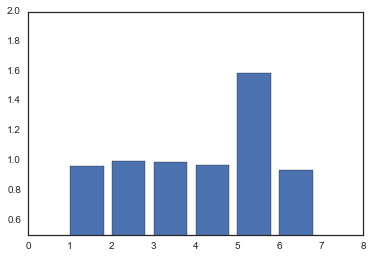

In [74]:
x = range(1,7)
y = [jaccard_1000,minkowski_1000,eucl_1000,dice_1000,cosine_1000,mahattan_1000]
plt.bar(x,y)
plt.xlim(0,8)
plt.ylim(0.5,2)

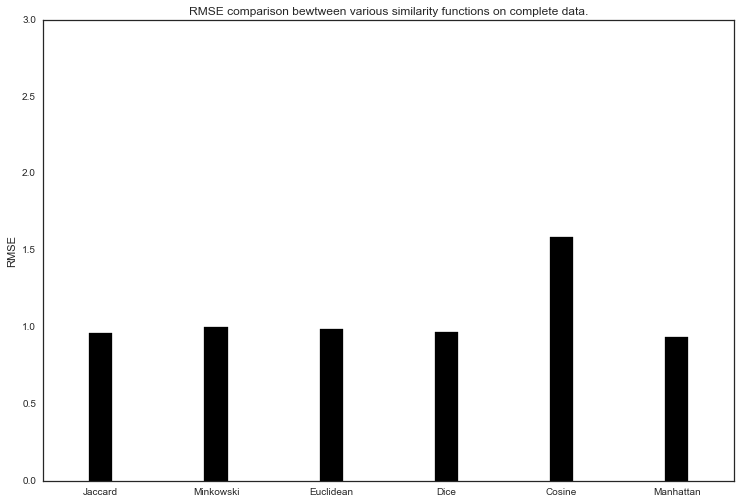

In [75]:
import pylab
f = pylab.figure(figsize=(12,8))
ax = f.add_axes([0.1, 0.1, 0.8, 0.8])
ax.bar(x, y, align='center',width=0.2, color="black")
ax.set_xticks(x)
ax.set_xticklabels(['Jaccard','Minkowski','Euclidean','Dice','Cosine','Manhattan'])
ax.set_xlim([0.5,6.5])
ax.set_ylim([0,3])
ax.set_ylabel("RMSE")
ax.set_title("RMSE comparison bewtween various similarity functions on complete data.")
f.savefig(filename="similariry_functions.jpg",bbox_inches='tight')

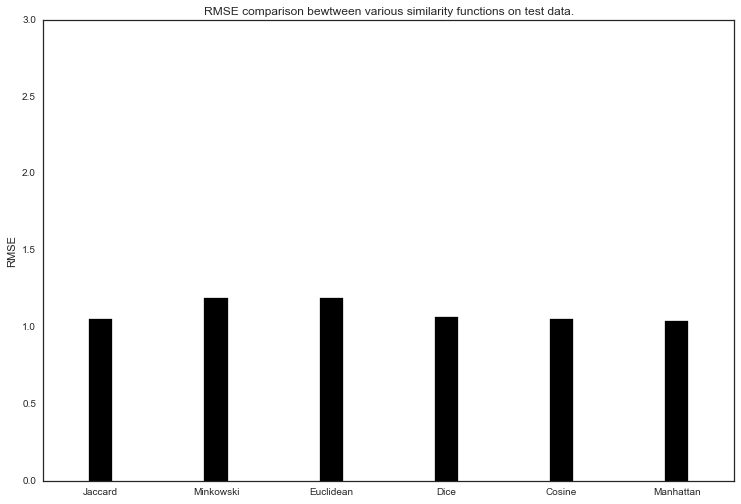

In [76]:
x = range(1,7)
y = [jaccard_300,minkowski_300,eucl_300,dice_300,cosine_300,manhattan_300]
f = pylab.figure(figsize=(12,8))
ax = f.add_axes([0.1, 0.1, 0.8, 0.8])
ax.bar(x, y, align='center',width=0.2, color="black")
ax.set_xticks(x)
ax.set_xticklabels(['Jaccard','Minkowski','Euclidean','Dice','Cosine','Manhattan'])
ax.set_xlim([0.5,6.5])
ax.set_ylim([0,3])
ax.set_ylabel("RMSE")
ax.set_title("RMSE comparison bewtween various similarity functions on test data.")
f.savefig(filename="similariry_functions_test.jpg",bbox_inches='tight')

In [ ]:
pso_data = pd.read_csv('./pso.csv')
#columns = pso_data.columns[:4]
#pso.columns = ['swarm_size','max_iter','finish_time','error']

In [ ]:
columns = pso_data.columns[:4]

In [ ]:
pso_data = pso_data[columns]

In [ ]:
pso_data
pso_data.columns = ['swarm_size','max_iter','finish_time','error']

In [ ]:
pso_data

In [ ]:
firefly_data = pd.read_csv('./firefly.csv')
columns = firefly_data.columns[:4]
firefly_data = firefly_data[columns]
firefly_data.columns = ['swarm_size','max_iter','finish_time','error']

In [ ]:
firefly_data.head()

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(firefly_data.max_iter, firefly_data.finish_time, '-', label="FA",c="0.1")
plt.plot(pso_data.max_iter, pso_data.finish_time, '--', label="PSO",c="0.1")
plt.title("Number of Iterations vs Completion Time (in sec)")
plt.legend()
plt.xlim([100,550])
plt.xlabel("Number of Iterations")
plt.ylabel("Completion Time")
plt.savefig(filename="iteration_time.jpg",bbox_inches='tight')

In [ ]:
# import math
# rmse_pso = math.sqrt(calculate_mse(weights))
pso_data['error'][3]

In [ ]:
firefly_weights = [1.68025248e-01,   6.33696638e-01,
          1.66857644e-01,   9.56715600e-01,   1.40681305e-02,
          5.67212948e-01,   1.00000000e+00,   6.86592048e-02,
          5.79232355e-01,   1.61788904e-01,   4.37825980e-01,
          3.69704405e-01,   0.00000000e+00,   4.01681141e-03,
          8.79106525e-01,   1.00000000e+00,   1.05052174e-01,
          1.07819948e-01,   2.72514379e-01,   3.28510792e-01,
          6.13944565e-01,   9.51533687e-02,   4.47570215e-01,
          1.30900553e-01,   2.16290656e-01,   6.44635553e-01,
          5.39704064e-01,   3.07633150e-01,   4.08444731e-01,
          1.21906170e-01,   8.90305749e-01,   7.84412855e-01,
          1.27553341e-02,   3.72605965e-01,   1.00000000e+00,
          9.32838295e-01,   4.78820245e-02,   5.38214725e-01,
          1.17678254e-01,   8.90642164e-01,   9.63329961e-01,
          5.95070050e-01,   1.71280877e-01,   8.36161037e-01,
          8.92182043e-01,   8.49683813e-01,   7.79639685e-01,
          4.30269157e-01,   1.47509001e-01,   6.26900403e-01,
          0.00000000e+00,   1.85521377e-01,   0.00000000e+00,
          8.12236457e-01,   3.09164602e-01,   9.12206287e-01,
          1.30752794e-01,   6.50837607e-01,   7.96365160e-01,
          2.73648179e-01,   7.36400471e-01,   0.00000000e+00,
          8.11443812e-01,   2.90960605e-01,   5.66172405e-01,
          2.83946883e-01,   1.93584952e-02,   0.00000000e+00,
          7.15086381e-01,   1.55208457e-01,   3.60413957e-01,
          1.00000000e+00,   1.36068943e-01,   5.51236193e-01]
pso_weights = [6.991025340806624744e-01,6.864600601424905024e-01,4.577271812056464828e-01,6.149641724232440820e-01,9.233228441591770919e-01,1.472056226177070534e-02,8.430557787731045583e-01,6.751057965208809852e-01,9.911109797898056684e-01,3.862303349207192871e-01,0.000000000000000000e+00,1.036704318254458052e-04,2.173106328552092403e-01,5.726397444991686569e-01,0.000000000000000000e+00,3.643106146455452610e-01,6.817808724091881656e-01,8.239947398097096087e-01,8.677191086806317344e-01,1.544605817412877669e-01,5.341773493326725797e-01,1.983626238302186250e-04,1.000000000000000000e+00,2.262375227399178804e-02,0.000000000000000000e+00,3.032814779006614558e-01,5.493174581777889864e-01,3.710592650635394785e-01,2.078290345498789993e-02,6.119626618786409011e-01,0.000000000000000000e+00,0.000000000000000000e+00,6.299069535185680691e-01,6.357850800082401888e-01,6.654054099204487205e-01,6.216289028085781460e-02,8.997043478538357952e-01,4.735720257070915595e-01,2.573173267430859945e-01,3.043953400517680485e-01,7.185977794447576672e-01,1.637464352945744439e-02,3.458274241513435432e-01,1.109355051208655261e-02,6.170920155398555984e-01,5.763464806065040635e-01,5.835127099390990946e-01,2.480718849071708865e-01,1.815783140317607791e-01,9.475015416394066969e-01,7.692050348184397695e-06,6.593428423157277063e-01,3.866610975531077909e-01,8.269520957416945928e-01,4.555524577485187132e-01,4.555217118352588024e-01,6.654185311852937046e-01,6.778156336804584958e-01,4.849310694210372842e-06,6.341067771092458692e-03,6.907898250408722740e-02,1.968814704515519376e-01,1.888917821851804901e-01,1.000000000000000000e+00,4.880525609153650857e-01,7.984339061873557686e-02,0.000000000000000000e+00,1.586031845535752771e-01,0.000000000000000000e+00,9.192661670781081540e-01,7.055951888894982336e-03,4.910685979937167156e-01,2.679131244364733599e-01,1.161900433009498551e-01]

In [ ]:
import math
rmse_pso = math.sqrt(calculate_mse(pso_weights))
rmse_firefly = math.sqrt(calculate_mse(firefly_weights))

In [ ]:
# ax = plt.axes()
# plt.bar([1,2], [rmse_pso,rmse_firefly], width=0.2, label=['pso','firefly'],align='center')
# plt.xlim([0,3])
# plt.ylim([0,3])
# # plt.tick_params(
# #     axis='x',          # changes apply to the x-axis
# #     which='both',      # both major and minor ticks are affected
# #     bottom='off',      # ticks along the bottom edge are off
# #     top='off',         # ticks along the top edge are off
# #     labelbottom='off')
# ax.set_xticks(x)
# ax.set_xticklabels(['PSO', 'Firefly'])
# plt.legend()

In [ ]:
import pylab
x = [1,1.6]
y = [rmse_pso,rmse_firefly]
f = pylab.figure(figsize=(12,8))
ax = f.add_axes([0.1, 0.1, 0.8, 0.8])
ax.bar(x, y, align='center',width=0.2, color="black")
ax.set_xticks(x)
ax.set_xticklabels(['PSO','Firefly'])
ax.set_xlim([0.5,2])
ax.set_ylim([0,3])
ax.set_title("RMSE comparison between PSO and FA.")
f.savefig(filename="Rmse_comparison.jpg",bbox_inches='tight')

In [ ]:
rmse_pso, rmse_firefly